In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import random
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import librosa

# Configuración del dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")
torch.cuda.set_per_process_memory_fraction(0.5)

Usando dispositivo: cuda


In [2]:
MAX_LEN = 660000
SR = 22050
T0 = MAX_LEN/22050
HOP_LENGTH = int(SR * 0.01)  # 10 ms hop length
WIN_LENGTH = int(SR * 0.03)  # 30 ms window length

X = []
y = []
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
for id, genre in enumerate(genres):
    for i in range(100):
        if not (i == 54 and genre == 'jazz'):
            x, _ = sf.read(f'../Data/genres_original/{genre}/{genre}.000{i:02}.wav')
            melspec = librosa.feature.melspectrogram(y=x[:MAX_LEN], sr=SR, hop_length=HOP_LENGTH, win_length=WIN_LENGTH, n_mels=80)
            melspec_db = librosa.power_to_db(melspec, ref=np.max)
            X.append(melspec_db)
            y.append(id)

In [3]:
X[0].shape

(80, 3001)

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=28, stratify=y
)
del X

print(f"Entrenamiento: {len(X_train)} pares")
print(f"Validación: {len(X_test)} pares")

NameError: name 'X' is not defined

In [23]:
class audiodataset(Dataset):
    def __init__(self, X, y):
        self.pairs = list(zip(X, y))
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        xs, ys = self.pairs[idx]

        return {
            'input': torch.tensor(xs.T).to(device=device, dtype=torch.float32),
            'target': F.one_hot(torch.tensor(ys), 10).to(device=device, dtype=torch.float32),
            'input_length': xs.T.shape,
            'target_length': 10
        }

train_dataset = audiodataset(X_train, y_train)
test_dataset = audiodataset(X_test, y_test)

In [24]:
train_dataset[1]

{'input': tensor([[-29.5133, -25.4010, -21.5595,  ..., -72.3795, -64.6649, -69.5537],
         [-28.3343, -30.0301, -20.8622,  ..., -69.9178, -62.7992, -66.4473],
         [-26.5026, -21.1515, -18.0198,  ..., -70.8299, -63.0643, -66.0508],
         ...,
         [-15.7754, -15.8552, -22.7489,  ..., -67.3829, -68.2668, -66.1259],
         [-14.5578, -13.3928, -20.2241,  ..., -63.7439, -64.9570, -65.2837],
         [-17.3486, -18.2323, -24.5041,  ..., -55.0664, -55.7808, -56.4503]],
        device='cuda:0'),
 'target': tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0'),
 'input_length': (3001, 80),
 'target_length': 10}

### RNN muchos a uno

In [55]:
class rnns(nn.Module):
    def __init__(self, seq_len, hidden_size):
        super().__init__()
        self.LSTM = nn.LSTM(input_size=seq_len, hidden_size=hidden_size, batch_first=True)
        self.Linear = nn.Linear(in_features = 2*hidden_size, out_features=10)

    def forward(self, input_seq):
        '''
        -> (batch_size, 3001, seq_len ~ 80)
        -> hidden:  (1, batch_size, hidden_size)
        -> cell:    (1, batch_size, hidden_size)
        -> context: (1, batch_size, 2*hidden_size) -> (batch, 2*hidden_size)
        '''
        _, (hidden, cell) = self.LSTM(input_seq)
        context = torch.cat((hidden, cell), dim=2).to(device)
        context = context.reshape(hidden.size(1), -1)
        outputs = self.Linear(context).to(device)
        return outputs

hidden = torch.zeros(1, 2, 15)
cell = torch.zeros(1, 2, 15)
context = torch.cat((hidden, cell), dim=2)
print(hidden.shape)
print(cell.shape)
print(context.shape)
print(context.reshape(hidden.size(1), -1).shape)

torch.Size([1, 2, 15])
torch.Size([1, 2, 15])
torch.Size([1, 2, 30])
torch.Size([2, 30])


In [68]:
# Definimos hiperparámetros
NUM_EPOCHS = 20
LEARNING_RATE = 0.001
HIDDEN_SIZE = 128*2

# Inicializa el modelo 
model = rnns(seq_len=80, hidden_size=HIDDEN_SIZE).to(device)

# Función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(f"Modelo creado con {sum(p.numel() for p in model.parameters())} parámetros")

Modelo creado con 351242 parámetros


In [57]:
# testeando
train_dataloader = DataLoader(train_dataset, batch_size=2)
val_dataloader = DataLoader(test_dataset, batch_size=2)

for batch_idx, batch in enumerate(val_dataloader):
    print(batch_idx)
    print(batch['input'].shape)
    print(batch['target'].shape)

0
torch.Size([2, 3001, 80])
torch.Size([2, 10])
1
torch.Size([2, 3001, 80])
torch.Size([2, 10])
2
torch.Size([2, 3001, 80])
torch.Size([2, 10])
3
torch.Size([2, 3001, 80])
torch.Size([2, 10])
4
torch.Size([2, 3001, 80])
torch.Size([2, 10])
5
torch.Size([2, 3001, 80])
torch.Size([2, 10])
6
torch.Size([2, 3001, 80])
torch.Size([2, 10])
7
torch.Size([2, 3001, 80])
torch.Size([2, 10])
8
torch.Size([2, 3001, 80])
torch.Size([2, 10])
9
torch.Size([2, 3001, 80])
torch.Size([2, 10])
10
torch.Size([2, 3001, 80])
torch.Size([2, 10])
11
torch.Size([2, 3001, 80])
torch.Size([2, 10])
12
torch.Size([2, 3001, 80])
torch.Size([2, 10])
13
torch.Size([2, 3001, 80])
torch.Size([2, 10])
14
torch.Size([2, 3001, 80])
torch.Size([2, 10])
15
torch.Size([2, 3001, 80])
torch.Size([2, 10])
16
torch.Size([2, 3001, 80])
torch.Size([2, 10])
17
torch.Size([2, 3001, 80])
torch.Size([2, 10])
18
torch.Size([2, 3001, 80])
torch.Size([2, 10])
19
torch.Size([2, 3001, 80])
torch.Size([2, 10])
20
torch.Size([2, 3001, 80])
t

In [69]:
#### Entrenamiento del modelo #####
BATCH_SIZE = 2
# DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

train_losses = []
val_losses = []

print("Iniciando entrenamiento...")
print("-" * 50)

for epoch in range(NUM_EPOCHS):
    # Entrenamiento
    model.train()
    train_loss = 0
    for batch_idx, batch in enumerate(val_dataloader):
        input = batch['input']
        target = batch['target']

        optimizer.zero_grad()
        
        output = model.forward(input)
        loss = criterion(output, target)
        
        loss.backward()

        # Gradient clipping para evitar exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_dataset)
    train_losses.append(train_loss)

    # Validación
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for batch_idx, batch in enumerate(val_dataloader):
            input = batch['input']
            target = batch['target']
            
            output = model.forward(input)
            loss = criterion(output, target)
            val_loss += loss.item()
    val_loss /= len(train_dataset)
    val_losses.append(val_loss)
    
    if (epoch + 1) % 5 == 0:
        print(f'Época {epoch+1}/{NUM_EPOCHS}')
        print(f'  Pérdida Entrenamiento: {train_loss:.4f}')
        print(f'  Pérdida Validación: {val_loss:.4f}')
        print(f'  {"Mejorando" if val_loss < min(val_losses[:-1] + [float("inf")]) else "Empeorando"}')

print("Entrenamiento completado!")

Iniciando entrenamiento...
--------------------------------------------------
Época 5/20
  Pérdida Entrenamiento: 10.5039
  Pérdida Validación: 10.8193
  Mejorando
Época 10/20
  Pérdida Entrenamiento: 9.2969
  Pérdida Validación: 9.0430
  Mejorando
Época 15/20
  Pérdida Entrenamiento: 9.3369
  Pérdida Validación: 6.2003
  Mejorando
Época 20/20
  Pérdida Entrenamiento: 10.6303
  Pérdida Validación: 8.9780
  Empeorando
Entrenamiento completado!


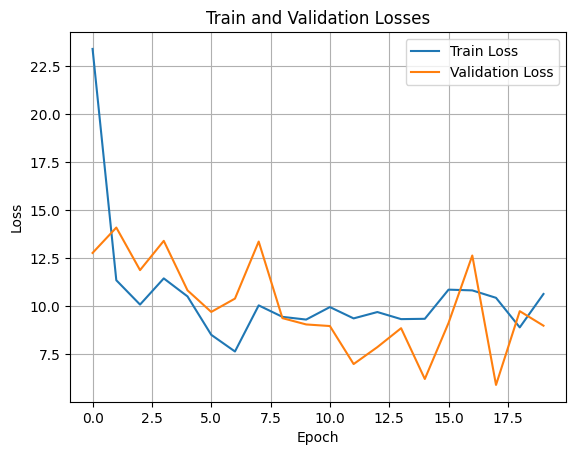

In [70]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#### Entrenamiento del modelo #####
BATCH_SIZE = 2
# DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

train_losses = []
val_losses = []

print("Iniciando entrenamiento...")
print("-" * 50)

for epoch in range(NUM_EPOCHS):
    # Entrenamiento
    model.train()
    train_loss = 0
    for batch_idx, batch in enumerate(val_dataloader):
        input = batch['input']
        target = batch['target']

        optimizer.zero_grad()
        
        output = model.forward(input)
        loss = criterion(output, target)
        
        loss.backward()

        # Gradient clipping para evitar exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_dataset)
    train_losses.append(train_loss)

    # Validación
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for batch_idx, batch in enumerate(val_dataloader):
            input = batch['input']
            target = batch['target']
            
            output = model.forward(input)
            loss = criterion(output, target)
            val_loss += loss.item()
    val_loss /= len(train_dataset)
    val_losses.append(val_loss)
    
    if (epoch + 1) % 5 == 0:
        print(f'Época {epoch+1}/{NUM_EPOCHS}')
        print(f'  Pérdida Entrenamiento: {train_loss:.4f}')
        print(f'  Pérdida Validación: {val_loss:.4f}')
        print(f'  {"Mejorando" if val_loss < min(val_losses[:-1] + [float("inf")]) else "Empeorando"}')

print("Entrenamiento completado!")

Iniciando entrenamiento...
--------------------------------------------------
Época 5/20
  Pérdida Entrenamiento: 10.5039
  Pérdida Validación: 10.8193
  Mejorando
Época 10/20
  Pérdida Entrenamiento: 9.2969
  Pérdida Validación: 9.0430
  Mejorando
Época 15/20
  Pérdida Entrenamiento: 9.3369
  Pérdida Validación: 6.2003
  Mejorando
Época 20/20
  Pérdida Entrenamiento: 10.6303
  Pérdida Validación: 8.9780
  Empeorando
Entrenamiento completado!


In [ ]:
# accuracy
model.eval()
accur = 0
with torch.no_grad():
    for item in test_dataset:
        input = item['input'].unsqueeze(0)
        target = item['target']

        output = model.forward(input)
        pred = F.one_hot(torch.argmax(output), 10)

        accur += int(sum(F.one_hot(torch.argmax(output), 10) == pred) == 10)

accur /= len(train_dataset)
print(f'Accuracy con los datos de validacion {accur:.4f}')

Accuracy con los datos de validacion 0.2503


In [ ]:
# Definimos hiperparámetros
NUM_EPOCHS = 500
LEARNING_RATE = 0.0001
HIDDEN_SIZE = 16

# Inicializa el modelo 
model = rnns(seq_len=80, hidden_size=HIDDEN_SIZE).to(device)

# Función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(f"Modelo creado con {sum(p.numel() for p in model.parameters())} parámetros")

#### Entrenamiento del modelo #####
BATCH_SIZE = 8
# DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

train_losses = []
val_losses = []

print("Iniciando entrenamiento...")
print("-" * 50)

for epoch in range(NUM_EPOCHS):
    # Entrenamiento
    model.train()
    train_loss = 0
    for batch_idx, batch in enumerate(val_dataloader):
        input = batch['input']
        target = batch['target']

        optimizer.zero_grad()
        
        output = model.forward(input)
        loss = criterion(output, target)
        
        loss.backward()

        # Gradient clipping para evitar exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_dataset)
    train_losses.append(train_loss)

    # Validación
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for batch_idx, batch in enumerate(val_dataloader):
            input = batch['input']
            target = batch['target']
            
            output = model.forward(input)
            loss = criterion(output, target)
            val_loss += loss.item()
    val_loss /= len(train_dataset)
    val_losses.append(val_loss)
    
    if (epoch + 1) % 5 == 0:
        print(f'Época {epoch+1}/{NUM_EPOCHS}')
        print(f'  Pérdida Entrenamiento: {train_loss:.4f}')
        print(f'  Pérdida Validación: {val_loss:.4f}')
        print(f'  {"Mejorando" if val_loss < min(val_losses[:-1] + [float("inf")]) else "Empeorando"}')

print("Entrenamiento completado!")

Modelo creado con 6602 parámetros
Iniciando entrenamiento...
--------------------------------------------------
Época 5/200
  Pérdida Entrenamiento: 1.3733
  Pérdida Validación: 0.7172
  Mejorando
Época 10/200
  Pérdida Entrenamiento: 0.0725
  Pérdida Validación: 0.0717
  Mejorando
Época 15/200
  Pérdida Entrenamiento: 0.0717
  Pérdida Validación: 0.0713
  Empeorando
Época 20/200
  Pérdida Entrenamiento: 0.0717
  Pérdida Validación: 0.0713
  Empeorando
Época 25/200
  Pérdida Entrenamiento: 0.0729
  Pérdida Validación: 0.0720
  Empeorando
Época 30/200
  Pérdida Entrenamiento: 0.0728
  Pérdida Validación: 0.0719
  Empeorando
Época 35/200
  Pérdida Entrenamiento: 0.0724
  Pérdida Validación: 0.0715
  Empeorando
Época 40/200
  Pérdida Entrenamiento: 0.0717
  Pérdida Validación: 0.0709
  Mejorando
Época 45/200
  Pérdida Entrenamiento: 0.0712
  Pérdida Validación: 0.0704
  Mejorando
Época 50/200
  Pérdida Entrenamiento: 0.0709
  Pérdida Validación: 0.0701
  Empeorando
Época 55/200
  Pérdida 

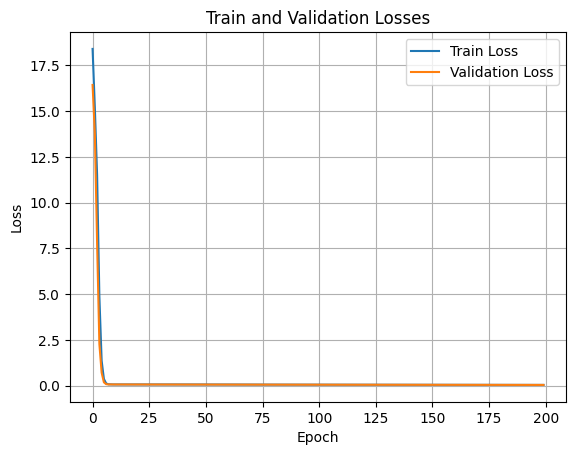

In [111]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

In [112]:
model.eval()
accur = 0
with torch.no_grad():
    for item in test_dataset:
        input = item['input'].unsqueeze(0)
        target = item['target']

        output = model.forward(input)
        pred = F.one_hot(torch.argmax(output), 10)
        accur += int(sum(pred == target) == 10)

accur /= len(test_dataset)
print(f'Accuracy con los datos de validacion {accur:.4f}')

Accuracy con los datos de validacion 0.4400
